In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/darcy')
from darcy_ms import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [3]:
%load_ext autoreload
%autoreload 2

In [88]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:0'

sublogdir = 'modelNGO_ctheta'
modelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO_noSE = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_noSE', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO_Neumann_noSE = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_Neumann_noSE', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO_Neumann = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_Neumann', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO_Neumann_tanhshrink = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_Neumann_tanhshrink', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO_abs = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_abs', logdir=logdir, sublogdir=sublogdir, device=device)
FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
FEM.hparams['modeltype'] = 'FEM'
FEM.hparams['dtype'] = torch.float64
FEM.hparams['precision'] = 64
FEM.hparams['Neumannseries'] = False
projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
projection.hparams['modeltype'] = 'projection'
projection.hparams['dtype'] = torch.float64
projection.hparams['precision'] = 64


modeldict = {'Projection': projection,
             #'FEM': FEM,
             'Model NGO': modelNGO_noSE,
            'SE Model NGO': modelNGO,
           'Neumann Model NGO': modelNGO_Neumann_noSE,
            #'SE Neumann Model NGO': modelNGO_Neumann,
            'SE Neumann Model NGO': modelNGO_Neumann_tanhshrink}
            #'SE Neumann model NGO': modelNGO_abs}

0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

/tmp/ipykernel_18206/3517988236.py:76: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(c_thetas, spectralradii_avg, yerr=yerr_radii, fmt=".-", capsize=6, ms=15, label='Spectral radius', color='red', linestyle='-'))
/tmp/ipykernel_18206/3517988236.py:92: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(c_thetas, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


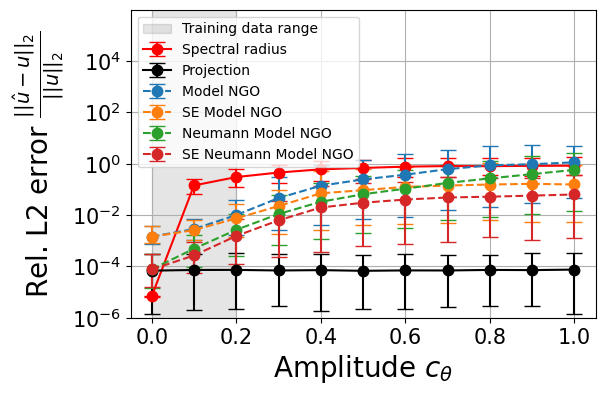

In [90]:
N_samples = 1000
lb = 0.02

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low


c_thetas = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# l = np.array([1])

# l = np.array([0.4, 0.3, 0.2, 0.1, 0.05])
L2_scaled_avg = np.zeros((len(modeldict),len(c_thetas)))
yerr = np.zeros((len(modeldict),2,len(c_thetas)))
spectralradii_avg = np.zeros(len(c_thetas))
yerr_radii = np.zeros((2,len(c_thetas)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

# quadrature = GaussLegendreQuadrature2D(n_elements=1, Q=100)
quadrature = UniformQuadrature2D(Q=100)
x = torch.tensor(quadrature.xi_Omega, device=device)
w = quadrature.w_Omega

linestyles=['-','--','--','--','--','--', '--','--','--','--','--','--']
colors = ['black','C0','C1','C2','C3','C4','C0','C1','C2','C3','C4']
# markers = ['o','^','o','^','o','^','o']
    
for i in range(len(c_thetas)):
    print(c_thetas[i])
    dataset = ManufacturedSolutionsSetDarcy_ctheta(N_samples=N_samples, variables=['x','x'], l_min=[0.5,0.5], l_max=[1,1], c_theta_min=c_thetas[i], c_theta_max=c_thetas[i], device=device)
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    m=0
    for model in modeldict:
        u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device).cpu().numpy()
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
        theta_d = discretize_functions(theta, modeldict[str(model)].xi_Omega, dtype=modeldict[str(model)].hparams['dtype'], device=device)
        theta_min = torch.amin(theta_d, axis=-1).cpu().numpy()
        if modeldict[str(model)].hparams['Neumannseries']==True:
            spectralradii = modeldict[str(model)].Neumann_criterion(theta).detach().cpu().numpy()
            spectralradii = spectralradii[theta_min>lb]
            spectralradii_avg[i] = np.average(spectralradii, axis=-1)
        q_l_radii = np.quantile(spectralradii, q_low)
        q_h_radii = np.quantile(spectralradii, q_high)
        yerr_radii[:,i] = np.array([spectralradii_avg[i] - q_l_radii, -spectralradii_avg[i] + q_h_radii])
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_array = L2_scaled_array[theta_min>lb]
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

    
# L2_scaled_avg[L2_scaled_avg<0] = np.nan
# yerr[yerr<0] = np.nan
        
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0,0.2, color='black', alpha=0.1, label='Training data range'))
plots.append(ax.errorbar(c_thetas, spectralradii_avg, yerr=yerr_radii, fmt=".-", capsize=6, ms=15, label='Spectral radius', color='red', linestyle='-'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Amplitude $c_\theta$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
# ax.set_xlim(1e-1, 1e1)
ax.set_ylim(1e-6, 1e6)
ax.set_yticks([1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4])
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
# ax.set_xscale('log')
ax.grid()
# ax.set_title(sublogdir, fontsize=size_title)
for model in modeldict:
    # ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m], marker='o')
    # plots.append(ax.plot(c_thetas, L2_scaled_avg[m], label=str(model), color=colors[m], linestyle=linestyles[m], marker='o')[0])
    plots.append(ax.errorbar(c_thetas, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
        # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
    m+=1
    # plt.legend(fontsize=10, loc='upper right')
    # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
plt.legend(fontsize=10, ncols=1)
# plt.legend(fontsize=8, loc='upper left', ncols=1)
# legend1 = ax.legend(handles=plots[0:3], fontsize=10, ncols=1, loc='lower right')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[3:6], fontsize=10, ncols=1, loc='upper left')
# plt.gca().add_artist(legend2)
# plt.savefig("NeumannmodelNGO.svg", bbox_inches='tight')#, transparent=True)

plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

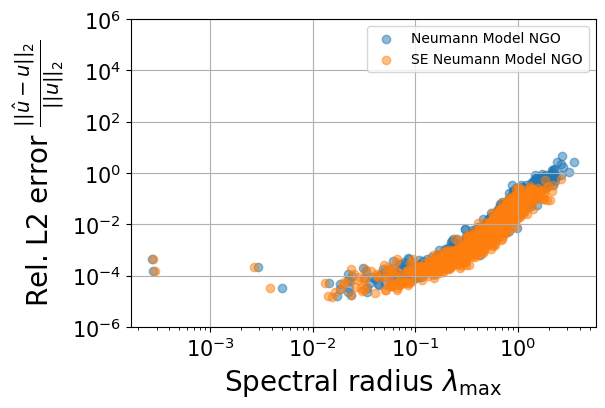

In [86]:
N_samples = 1000
lb = 0.02

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low


# c_thetas = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# l = np.array([1])

# l = np.array([0.4, 0.3, 0.2, 0.1, 0.05])
L2_scaled_array = np.zeros((len(modeldict),N_samples))
spectralradii = np.zeros((len(modeldict),N_samples))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

# quadrature = GaussLegendreQuadrature2D(n_elements=1, Q=100)
quadrature = UniformQuadrature2D(Q=108)
x = torch.tensor(quadrature.xi_Omega, device=device)
w = quadrature.w_Omega

linestyles=['-','-','--','--','--','--', '--','--','--','--','--','--']
colors = ['C0','C1','C2','C3','C4','C0','C1','C2','C3','C4']
# markers = ['o','^','o','^','o','^','o']
    
dataset = ManufacturedSolutionsSetDarcy_ctheta(N_samples=N_samples, variables=['x','x'], l_min=[0.5,0.5], l_max=[1,1], c_theta_min=0, c_theta_max=1, device=device)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
m=0
# model = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_Neumann_noSE', logdir=logdir, sublogdir=sublogdir, device=device)
# spectralradii = model.Neumann_criterion(theta).detach().cpu().numpy()
# spectralradii_avg[i] = np.median(spectralradii, axis=-1)
# q_l_radii = np.quantile(spectralradii, q_low)
# q_h_radii = np.quantile(spectralradii, q_high)
for model in modeldict:
    spectralradii[m] = modeldict[str(model)].Neumann_criterion(theta).detach().cpu().numpy()
    u_exact = discretize_functions(u, x, dtype=modeldict[str(model)].hparams['dtype'], device=device).cpu().numpy()
    u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    theta_d = discretize_functions(theta, modeldict[str(model)].xi_Omega, dtype=modeldict[str(model)].hparams['dtype'], device=device)
    theta_min = torch.amin(theta_d, axis=-1).cpu().numpy()
    L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
    L2_diff = L22_diff**(1/2)
    L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
    L2_norm = L22_norm**(1/2)
    L2_scaled_array[m] = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
    
    # L2_scaled_avg[m,i] = np.median(L2_scaled_array)
    # q_l = np.quantile(L2_scaled_array, q_low)
    # q_h = np.quantile(L2_scaled_array, q_high)
    # yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
    m+=1

    
# L2_scaled_avg[L2_scaled_avg<0] = np.nan
# yerr[yerr<0] = np.nan
        
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
# plots.append(ax.axvspan(0,0.2, color='black', alpha=0.1, label='Training data range'))
# plots.append(ax.errorbar(c_thetas, spectralradii_avg, yerr=yerr_radii, fmt=".-", capsize=6, ms=15, label='Spectral radius', color='red', linestyle='-'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Spectral radius $\lambda_\mathrm{max}}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
# ax.set_xlim(1e-1, 1e1)
ax.set_ylim(1e-6, 1e6)
# ax.set_xticks([1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4])
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
ax.set_xscale('log')
ax.grid()
# ax.set_title(sublogdir, fontsize=size_title)
for model in modeldict:
    # ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m], marker='o')
    # plots.append(ax.plot(c_thetas, L2_scaled_avg[m], label=str(model), color=colors[m], linestyle=linestyles[m], marker='o')[0])
    plots.append(ax.scatter(spectralradii[m,theta_min>lb], L2_scaled_array[m,theta_min>lb], label=str(model), alpha=0.5))#,c=theta_bar[theta_bar>lb]))
    # plots.append(ax.errorbar(c_thetas, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
        # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
    m+=1
    # plt.legend(fontsize=10, loc='upper right')
    # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
plt.legend(fontsize=10, ncols=1)
# plt.legend(fontsize=8, loc='upper left', ncols=1)
# legend1 = ax.legend(handles=plots[0:2], fontsize=10, ncols=1, loc='lower right')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:7], fontsize=10, ncols=1, loc='upper left')
# plt.gca().add_artist(legend2)
# plt.colorbar(plots[0])
plt.savefig("errorvsspectralradius_noSE.svg", bbox_inches='tight')#, transparent=True)

plt.show()